In [27]:
import numpy as np
import pandas as pd
import sklearn.linear_model as linear
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sb
import warnings
import missingno as msn
warnings.filterwarnings('ignore')

In [105]:
dhs_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_AggregatedFoodGroups_27June2019.csv")

# For merging with complete dataset later
dhs_ungrouped_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_27June2019.csv")

In [29]:
dhs_df.head()

,Cell_Order,fruits,Num_Households_Responded_fruits,vegetables,Num_Households_Responded_vegetables,dairy,Num_Households_Responded_dairy,eggs,Num_Households_Responded_eggs,meat_fish,...,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Fruits - Excluding Wine,Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,Cons_kg.yr Starchy Roots,Cons_kg.yr Sugar & Sweeteners,Cons_kg.yr Vegetables
0,2158169,0.179487,13.0,0.494505,13.0,0.159341,13.0,0.346520,13.0,0.480220,...,17.324,15.084,52.856,51.040,156.888,2.434,1.542,135.794,47.558,154.956
1,2158170,0.227965,16.0,0.113839,16.0,0.353051,16.0,0.046875,16.0,0.280072,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
2,2158171,0.166450,11.0,0.282359,11.0,0.319772,11.0,0.106585,11.0,0.136905,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
3,2158173,0.321429,7.0,0.054945,7.0,0.877060,7.0,0.269231,7.0,0.153846,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
4,2158174,0.207953,14.0,0.199923,14.0,0.190168,14.0,0.178890,14.0,0.086466,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622


### Preparing Dataset

In [30]:
# Merge with global data
production_df = pd.read_csv("datasets/production_avg_2011_2013.csv")
socio_economic_df = pd.read_csv("datasets/master.csv")

In [31]:
# This dataset does not have ISO3C GONNA add that. 
env_df = pd.read_excel("datasets/analysis4_environment_finaldata.xlsx")

In [32]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2,country_name_to_country_alpha3,country_alpha3_to_country_alpha2

In [33]:
def convert_to_iso3c(countries):
    """
    This function tries to get the continent based on Country name.
    Since some countries names are differnt in the library we are using here,
    need to manually change those.
    
    This function also tries to rechieve an alpha 3 Country Code based on the name. 
    """
    country_codes = []
    for country in countries:
        try:
            country_code = country_name_to_country_alpha3(country)
            country_codes.append(country_code)
        except KeyError:
            print(country)
            country_codes.append(country)
    return country_codes

In [34]:
country_codes = convert_to_iso3c(env_df["Country"])


Bolivia (Plurinational State of)
CÃ´te d'Ivoire
Channel Islands
China, Hong Kong SAR
China, Macao SAR
China, mainland
China, Taiwan Province of
Eswatini
Holy See
Iran (Islamic Republic of)
Micronesia (Federated States of)
Netherlands Antilles (former)
North Macedonia
Pitcairn Islands
RÃ©union
Republic of Korea
Sudan (former)
Svalbard and Jan Mayen Islands
Venezuela (Bolivarian Republic of)
Wallis and Futuna Islands


In [35]:
manual_country_code_dict = {"Bolivia (Plurinational State of)":"BOL"
                            ,"Channel Islands":""
                         ,"China, Hong Kong SAR":"HKG"
                         ,"China, mainland":"CHN"
                         ,"China, Macao SAR":"MAC"
                         ,"China, Taiwan Province of":"TWN"
                         ,"Holy See":"VAT"
                         ,"CÃƒÂ´te d'Ivoire":"CIV"
                            ,"CÃ´te d'Ivoire":"CIV"
                        ,"Pitcairn Islands":"PCN"
                        ,"Iran (Islamic Republic of)":"IRN"
                        ,"Republic of Korea":"KOR"
                        ,"Eswatini":"SWZ"
                        ,"RÃ©union":"REU"
                        ,"Netherlands Antilles (former)":"ANT"
                        ,"Svalbard and Jan Mayen Islands":"SJM"
                        ,"Sudan (former)":"SDN"
                        ,"North Macedonia":"MKD"
                        ,"Republic of North Macedonia":"MKD"
                        ,"Timor-Leste":"TLS"
                        ,"Wallis and Futuna Islands":"WLF"
                        ,"Venezuela (Bolivarian Republic of)":"VEN"}


In [36]:
# principalDf.to_csv("test.csv")
env_df["ISO3C"] = country_codes
env_df["ISO3C"] = env_df["ISO3C"].replace(manual_country_code_dict)

In [37]:
dhs_merged_df = dhs_df.merge(socio_economic_df, how="left", left_on= "ISO3C", right_on = "Country Code")
dhs_merged_env_df = dhs_merged_df.merge(env_df, how="left", on= "ISO3C")
dhs_ml_df = dhs_merged_env_df.merge(production_df,how = "left",left_on = "ISO3C",right_on = "Code")

In [38]:
dhs_ml_df.columns

Index(['Cell_Order', 'fruits', 'Num_Households_Responded_fruits', 'vegetables',
       'Num_Households_Responded_vegetables', 'dairy',
       'Num_Households_Responded_dairy', 'eggs',
       'Num_Households_Responded_eggs', 'meat_fish',
       'Num_Households_Responded_meat_fish', 'nuts_pulses',
       'Num_Households_Responded_nuts_pulses', 'sweets',
       'Num_Households_Responded_sweets', 'grains_tubers',
       'Num_Households_Responded_grains_tubers', 'animal_source_foods',
       'Num_Households_Responded_animal_source_foods', 'Cell_Order.1', 'ISO3N',
       'Primary_Religion', 'Percent_Primary_Religion', 'Percent_Christian',
       'GDP_PPP_2015', 'GDP_PPP_2000', 'GDP_PPP_1990', 'Population_2015',
       'Population_2000', 'Population_1990', 'Travel_time_to_cities',
       'Soil_suit_overall', 'Soil_suit_cereals', 'Soil_suit_fruits',
       'Soil_suit_veges', 'Soil_suit_nuts_seeds', 'Soil_suit_pulses',
       'Soil_suit_roots', 'Soil_suit_chocolate', 'Soil_suit_coffee',
       

In [39]:
# Before finding a dataset with better percapita GDP, I am not going to use that for the prediction. 
# There is just too much missing data.

# dhs_predictor_socio_cols = ['PerCapita_GDP_2015','agri_gdp_percentage(AVG from 2011 to 2013)',
#                            'AVG GDP 2011-2013 Constant 2010']

dhs_predictor_socio_cols = ['ari_employment value (AVG 2011-2013)',
                            'agri_gdp_percentage(AVG from 2011 to 2013)',
                           'AVG GDP 2011-2013 Constant 2010']

dhs_predictor_consump_cols = ['Cons_kg.yr Cereals - Excluding Beer', 'Cons_kg.yr Eggs'
                        ,'Cons_kg.yr Fish, Seafood'
                       ,'Cons_kg.yr Meat', 'Cons_kg.yr Milk - Excluding Butter'
                       ,'Cons_kg.yr Nuts_and_Seeds', 'Cons_kg.yr Pulses'
                       ,'Cons_kg.yr Starchy Roots']

# Protected Marine is missing so much. Not using here. 
dhs_predictor_env_cols = ['Agricultural Emissions (CO2eq)'
                           ,'Protected_Terrestrial'
                          , 'Forest_change' 
                          , 'Redlist'
                         ,'Freshwater']

dhs_predictor_production_cols = ['Fish, Seafood', 'Bovine_Sheep_Pigmeat_Poultry', 'Milk_Egg', 'Cereals']
                    
dhs_predictor_other_cols = ['Population_2015','Primary_Religion', 'Travel_time_to_cities','Soil_suit_overall', 'Soil_suit_cereals']

dhs_outcome_cols = ['eggs','dairy','meat_fish','nuts_pulses','grains_tubers','animal_source_foods']


In [124]:
dhs_ml_grouped_df = dhs_ml_df[dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                            dhs_predictor_env_cols +\
                      dhs_predictor_production_cols +\
                     dhs_predictor_other_cols +\
                        dhs_outcome_cols + ["Cell_Order"]]

In [125]:
dhs_ml_grouped_df.head()

,ari_employment value (AVG 2011-2013),agri_gdp_percentage(AVG from 2011 to 2013),AVG GDP 2011-2013 Constant 2010,Cons_kg.yr Cereals - Excluding Beer,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,...,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods,Cell_Order
0,20.081334,8.266235,1.440000e+11,140.708,17.324,15.084,51.040,156.888,2.434,1.542,...,82.41833,8.561080,8.491615,0.346520,0.159341,0.480220,0.159341,0.841392,0.986081,2158169
1,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,74.77269,8.511680,8.491615,0.046875,0.353051,0.280072,0.074219,0.447915,0.679998,2158170
2,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,96.45230,8.313398,8.491615,0.106585,0.319772,0.136905,0.150000,0.609615,0.563262,2158171
3,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,92.95013,7.087249,6.998866,0.269231,0.877060,0.153846,0.075549,0.756868,1.300137,2158173
4,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,104.31820,6.766561,6.492069,0.178890,0.190168,0.086466,0.182649,0.686842,0.455523,2158174


In [126]:
def overview(df):
    """
    This is a method to show number of missing values in our dataset.
    """
    print("Datasets shape Rows:{} Columns:{}".format(df.shape[0],df.shape[1]))
    print("----------Number of Missing Values in Each Column------------")
    nan_series = df.isnull().sum(axis = 0)
    print(nan_series)
    print("-------------------------------------------------------------")
    nan_series_trun = df.isnull().sum(axis = 1)
    print("Number of rows with more than 2 missing values:{}".format(nan_series_trun[nan_series_trun > 2].shape))
    # Number of empty data in rows
    print("Number of rows with 0 missing values:{}".format(nan_series_trun[nan_series_trun == 0].shape))


In [109]:
# Merging with ungrouped dataframe and we only need certain columns.
cols = dhs_ungrouped_df.columns.tolist()

In [133]:
# Get only the columns we want 
ungrouped_items = [ i for i in cols if "Gave" in i and "Num" not in i]
ungrouped_items_with_order = ungrouped_items + ["Cell_Order"]
dhs_ml_ungrouped_df = dhs_ungrouped_df[ungrouped_items_with_order]

In [135]:
# Group it with our dataframe. 
dhs_ml_final_df = dhs_ml_ungrouped_df.merge(dhs_ml_grouped_df,on = "Cell_Order", how = "inner")

Datasets shape Rows:33648 Columns:52
----------Number of Missing Values in Each Column------------
Gave.child.plain.water                                                18304
Gave.child.juice                                                      18322
Gave.child.tea.or.coffee                                              25798
Gave.child.tinned..powdered.or.fresh.milk                             19426
Gave.child.baby.formula                                               18303
Gave.child.soup.clear.broth                                           19623
Gave.child.other.liquid                                               18303
Gave.child.bread..noodles..other.made.from.grains                     19427
Gave.child.potatoes..cassava..or.other.tubers                         19424
Gave.child.eggs                                                       18303
Gave.child.any.dark.green.leafy.vegetables                            18304
Gave.child.aprictos..peaches.or.canteloupe..other.vitamin.A.fruit

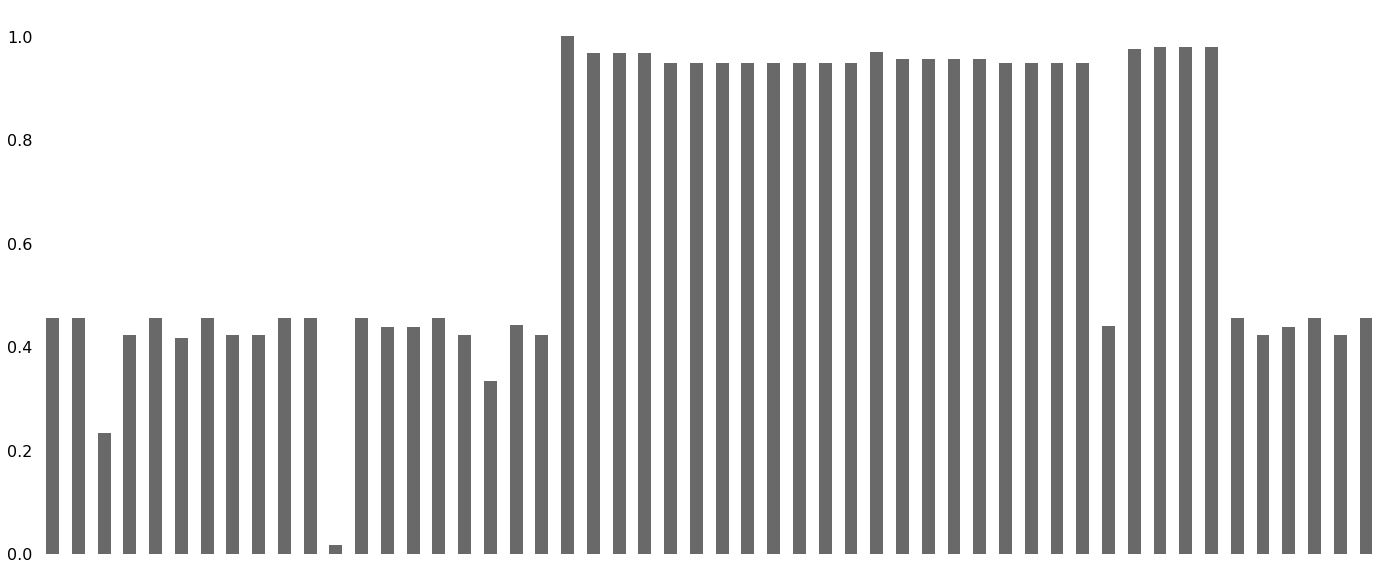

In [136]:
# Her Let's take a look at out dataset and visualize the missing values
overview(dhs_ml_final_df)
msn.bar(dhs_ml_final_df)

In [44]:
# Describe the df for later binning 
dhs_ml_final_df.describe()

,ari_employment value (AVG 2011-2013),agri_gdp_percentage(AVG from 2011 to 2013),AVG GDP 2011-2013 Constant 2010,Cons_kg.yr Cereals - Excluding Beer,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,...,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods,Cell_Order
count,32581.000000,32578.000000,3.257800e+04,31881.000000,31881.000000,31881.000000,31881.000000,31881.000000,31881.000000,31872.000000,...,32939.000000,32961.000000,32931.000000,15345.000000,14236.000000,14736.000000,15340.000000,14224.000000,15345.000000,3.364800e+04
mean,46.679840,18.176058,9.091100e+11,144.706844,2.950986,9.126167,15.445106,60.463532,7.486044,10.156463,...,84.798110,3.688729,4.846408,0.179753,0.307593,0.214108,0.214947,0.771712,0.660764,3.969616e+06
std,14.934237,9.091879,8.990694e+11,30.458665,2.708166,9.451910,15.959489,41.710871,4.752528,5.416853,...,182.562834,2.446650,1.706362,0.180282,0.292580,0.180763,0.196897,0.307004,0.427353,8.370142e+05
min,0.623667,1.364670,9.170050e+08,45.702000,0.230000,0.070000,4.066000,2.764000,0.004000,0.002000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.158169e+06
25%,42.874667,13.700025,2.292143e+10,131.332000,1.868000,5.250000,4.246000,31.192000,4.804000,6.698000,...,15.276630,1.522746,3.683363,0.055462,0.125000,0.080890,0.085714,0.607393,0.400754,3.346846e+06
50%,47.521333,17.061925,3.200000e+11,151.158000,2.012000,5.250000,8.174000,69.348000,7.328000,11.668000,...,36.842740,4.077061,4.945596,0.142929,0.250000,0.201016,0.172891,0.752357,0.621857,3.804738e+06
75%,47.521333,18.852912,1.870000e+12,151.158000,2.820000,7.790000,20.950000,69.348000,7.328000,11.668000,...,89.269055,5.743971,5.965635,0.246375,0.400000,0.305816,0.285714,0.916667,0.839160,4.399012e+06
max,91.581001,52.047069,7.200000e+12,257.928000,18.566000,52.438000,97.278000,336.916000,31.880000,35.386000,...,4653.946000,8.809972,8.998034,1.000000,3.000000,2.000000,1.000000,2.000000,6.000000,6.452155e+06


In [45]:
def draw_heat_map(df):
    """This is a function that uses seaborn's heatmap function to show correlations between our predictors and the outcome variables. """
    df_mat = df.corr()
    df_fig = plt.figure(figsize = (15,15))
    sb.heatmap(df_mat, vmax = .9, square = True, annot=True)

In [46]:

def separate_training_testing(myData):
    """
    This function seperates the training sets and validation sets.
    """
    valueArray = myData.values
    X = valueArray[:, 0:myData.shape[1] - 1]
    Y = valueArray[:, myData.shape[1] - 1]
    test_size = 0.15
    seed = 7
    X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=test_size, random_state=seed)
    return X_train, X_validate, Y_train, Y_validate


In [47]:
# Check if there is any low variance 
# Code from https://www.programcreek.com/python/example/93973/sklearn.feature_selection.VarianceThreshold
def feature_select(df):
    x_train, x_test, y_train, y_test = separate_training_testing(df)
    selector = VarianceThreshold()
    selector.fit(x_train, y_train)

    # Retain the feature names
    features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
#     features = [column for column in df[features] if column != target]  # Gets feature names
    print(features)

### Machine Learning 

In [48]:
def string_to_int(df, col_name):
    """
    This is a helper function for converting the string labels to numerical
    """
    m = {}
    for i,e in enumerate(df[col_name].unique()):
        m.update({e: i})
    return m

In [49]:
def create_bins_width(df, col_name, bin_width):
    """
    This function cuts bins using equal width method
    """
    max = df[col_name].max()
    min = df[col_name].min()
    bins = np.arange(min, max, bin_width)
    print('This cuts the {} array into {} bins in equal width'.format(col_name,len(bins)))
    new_col_name = col_name + "_group"
    df[new_col_name] = np.digitize(df[col_name], bins)
    return df


def create_bins_depth(df, col_name, bin_num):
    """
    This function cuts bins using equal depth method
    """
    new_col_name = col_name + "_group"
    df[new_col_name],bins= pd.qcut(df[col_name],bin_num, retbins=True, labels=list(range(bin_num)))
    print('This cuts the {} array into {} result in {} bins in equal depth'.format(col_name,bins,bin_num))
    df[new_col_name] = df[new_col_name].astype(int)
    df = df.drop(col_name, axis=1)
    return df 

In [50]:
def clean_data(df):
    #   Making an assumption here that NA religion is no religion. 
    df["Primary_Religion"] = df["Primary_Religion"].fillna("No Religion")
    
    result_df = df.dropna()
    
    m = string_to_int(result_df, "Primary_Religion")
    result_df["Primary_Religion"] = result_df["Primary_Religion"].map(m)
    create_bins_width(result_df,"Travel_time_to_cities",10)
    create_bins_width(result_df,"Soil_suit_overall",2)
    create_bins_width(result_df,"Soil_suit_cereals",2)
    
    for c in dhs_predictor_consump_cols:
        result_df = create_bins_width(result_df,c,5)
    
    for p in dhs_predictor_production_cols:
        result_df = create_bins_width(result_df,p,500)
        
    create_bins_width(result_df,'ari_employment value (AVG 2011-2013)',5)
    create_bins_width(result_df,'Agricultural Emissions (CO2eq)',10000)
    create_bins_width(result_df,'Protected_Terrestrial',10)
    create_bins_width(result_df,'Forest_change',1)
    create_bins_width(result_df,'Redlist',0.15)
    create_bins_width(result_df,'Freshwater',2)
    
    
    result_df["agri_gdp_percentage(AVG from 2011 to 2013)"].astype(float,inplace = True)
    result_df["AVG GDP 2011-2013 Constant 2010"].astype(float,inplace = True)
    
#     create_bins_width(result_df,"PerCapita_GDP_2015",1000)
    create_bins_width(result_df,"Population_2015",5000)
    
    create_bins_width(result_df,"agri_gdp_percentage(AVG from 2011 to 2013)",5)
    create_bins_width(result_df,"AVG GDP 2011-2013 Constant 2010",1000000)
    
    return result_df

In [53]:
def clean_outcome(df,col):
    """
    This function cleans our outcome variables.abs 
    It converts continous value into categorical value by cutting them into different bins.
    All the bins same size. 
    """
    df.dropna(inplace = True)
    if col == "eggs" or col == "nuts_pulses":
        result_df = create_bins_width(df,col,0.25)
    else:
        result_df = create_bins_width(df,col,0.5)
    
    result_df = result_df[[col+'_group',"Cell_Order"]]
    return result_df
    

In [52]:
# Gather the desired cols that we will be using. 
desired_cols = dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                      dhs_predictor_production_cols +\
                    dhs_predictor_env_cols +\
                     dhs_predictor_other_cols 

# Instead of dropping na with the whole dataset which might cause loosing data entries, I am going to seperate the outcome variabels.
cleaned_dhs_df = clean_data(dhs_ml_final_df[desired_cols + ["Cell_Order"]])

This cuts the Travel_time_to_cities array into 322 bins in equal width
This cuts the Soil_suit_overall array into 5 bins in equal width
This cuts the Soil_suit_cereals array into 5 bins in equal width
This cuts the Cons_kg.yr Cereals - Excluding Beer array into 43 bins in equal width
This cuts the Cons_kg.yr Eggs array into 4 bins in equal width
This cuts the Cons_kg.yr Fish, Seafood array into 11 bins in equal width
This cuts the Cons_kg.yr Meat array into 19 bins in equal width
This cuts the Cons_kg.yr Milk - Excluding Butter array into 67 bins in equal width
This cuts the Cons_kg.yr Nuts_and_Seeds array into 7 bins in equal width
This cuts the Cons_kg.yr Pulses array into 8 bins in equal width
This cuts the Cons_kg.yr Starchy Roots array into 81 bins in equal width
This cuts the Fish, Seafood array into 114 bins in equal width
This cuts the Bovine_Sheep_Pigmeat_Poultry array into 162 bins in equal width
This cuts the Milk_Egg array into 272 bins in equal width
This cuts the Cereals 

In [98]:
desired_group_cols = [i+"_group" for i in desired_cols]
desired_group_cols.append("Cell_Order")
desired_group_cols.remove('Primary_Religion_group')
desired_group_cols.append('Primary_Religion')
cleaned_dhs_grouped_df = cleaned_dhs_df[desired_group_cols] 

In [99]:
cleaned_egg_df = clean_outcome(dhs_ml_final_df[["eggs","Cell_Order"]],"eggs")
cleaned_ml_egg_df = cleaned_egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_egg_df = cleaned_ml_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_egg_df.drop(["Cell_Order"], axis=1,inplace = True)
cleaned_ml_egg_df.head()

This cuts the eggs array into 4 bins in equal width


,ari_employment value (AVG 2011-2013)_group,agri_gdp_percentage(AVG from 2011 to 2013)_group,AVG GDP 2011-2013 Constant 2010_group,Cons_kg.yr Cereals - Excluding Beer_group,Cons_kg.yr Eggs_group,"Cons_kg.yr Fish, Seafood_group",Cons_kg.yr Meat_group,Cons_kg.yr Milk - Excluding Butter_group,Cons_kg.yr Nuts_and_Seeds_group,Cons_kg.yr Pulses_group,...,Protected_Terrestrial_group,Forest_change_group,Redlist_group,Freshwater_group,Population_2015_group,Travel_time_to_cities_group,Soil_suit_overall_group,Soil_suit_cereals_group,Primary_Religion,eggs_group
0,4,2,143040,20,4,4,10,31,1,1,...,1,6,2,5,1,9,5,5,0,2
1,6,2,6613,21,2,3,7,31,1,1,...,1,1,3,5,1,8,5,5,0,1
2,6,2,6613,21,2,3,7,31,1,1,...,1,1,3,5,1,10,5,5,0,1
3,6,2,6613,21,2,3,7,31,1,1,...,1,1,3,5,2,10,4,4,0,2
4,4,2,143040,20,4,4,10,31,1,1,...,1,6,2,5,4,6,5,5,0,1


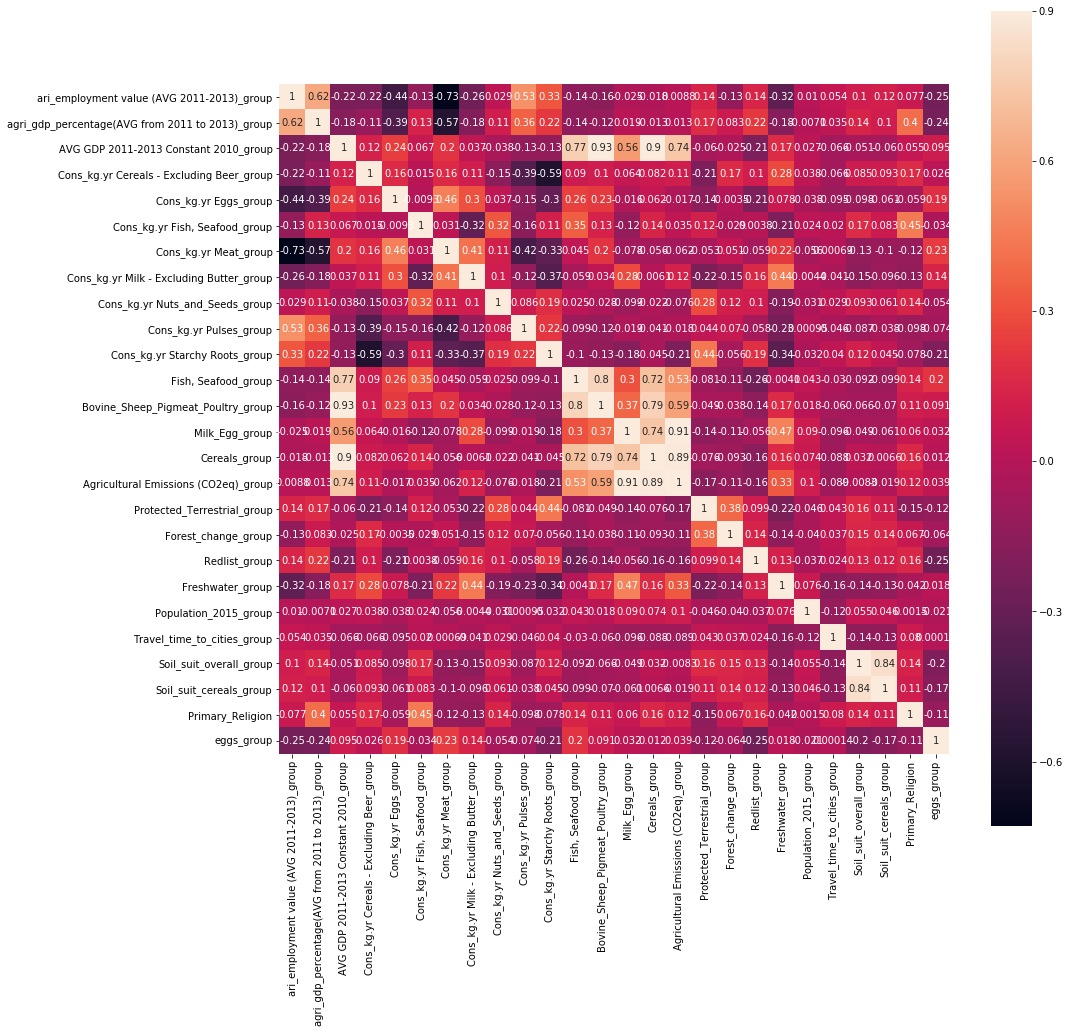

In [100]:
# Let's look at the heapmap of egg
draw_heat_map(cleaned_ml_egg_df)

In [57]:
overview(cleaned_ml_egg_df)

Datasets shape Rows:6060 Columns:25
----------Number of Missing Values in Each Column------------
ari_employment value (AVG 2011-2013)_group          0
agri_gdp_percentage(AVG from 2011 to 2013)_group    0
AVG GDP 2011-2013 Constant 2010_group               0
Cons_kg.yr Cereals - Excluding Beer_group           0
Cons_kg.yr Eggs_group                               0
Cons_kg.yr Fish, Seafood_group                      0
Cons_kg.yr Meat_group                               0
Cons_kg.yr Milk - Excluding Butter_group            0
Cons_kg.yr Nuts_and_Seeds_group                     0
Cons_kg.yr Pulses_group                             0
Cons_kg.yr Starchy Roots_group                      0
Fish, Seafood_group                                 0
Bovine_Sheep_Pigmeat_Poultry_group                  0
Milk_Egg_group                                      0
Cereals_group                                       0
Agricultural Emissions (CO2eq)_group                0
Protected_Terrestrial_group           

In [58]:
# I am also interested in precision and recall score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [165]:
def draw_roc_curve(name, model, X_validate, Y_validate):
    """
    This functions draws ROC graphs.
    """
    predicted_probas = model.predict_proba(X_validate)
    skplt.metrics.plot_roc(Y_validate, predicted_probas, title = "Roc Curve of {}".format(name))
    plt.show()
    # uncomment here to save the plots
    # plt.savefig(name)


def plot_confusion_matrix(Y_pred, Y_validate, name, out_come):
    """
    This function plots the confusion matrix.
    """

    skplt.metrics.plot_confusion_matrix(Y_validate, Y_pred,title = "Predicting {} Using {} Confusion Matrix".format(out_come, name))
    plt.show()
    
    # uncomment here to save the plots(Included in the write-up)
    # plt.savefig("cnf_matrix " + name)


def model_evaluate(X_train, X_validate, Y_train, Y_validate, num_folds, num_instances, seed, scoring, models, out_come, no_kfold):
    """
    This function handles evaluation of machine learning methods using cross validation 
    """
    results = []
    for name, model in models:

        # Get a prediction
        trained_model = model.fit(X_train, Y_train)
            
        Y_pred = trained_model.predict(X_validate)
        
        # Plot the condusion matrix and Roc curve
        plot_confusion_matrix(Y_pred, Y_validate, name, out_come)
#         draw_roc_curve(name, trained_model, X_validate, Y_validate)
        print("Predicting {} Using {} Accuracy: {} Precision:{} Recall:{}".format(out_come,name
                                                                                  ,accuracy_score(Y_validate,Y_pred)
                                                                                  ,precision_score(Y_validate,Y_pred,average='macro')
                                                                                  ,recall_score(Y_validate,Y_pred,average='macro')))
        # Evalutate out models 
        # TODO 
        if no_kfold == False:
            kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=False)
            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
            results.append(cv_results)
            msg = "Predicting {} Using {} model's accuracy is {}, with a standard deviation of {}".format(out_come, name, cv_results.mean(), cv_results.std())
            print(msg)
        elif no_kfold:
            print(model.best_params_)
                
def perform_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    models = [('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()),
                    ('RFC', RandomForestClassifier()), ('NB', GaussianNB())
#                     ,('SVM', svm.SVC(gamma=0.001, decision_function_shape='ovo', probability=True))
             ]
    
#     models = [('RFC', RandomForestClassifier())]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', models, out_come,False)

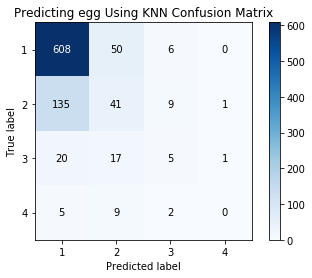

Predicting egg Using KNN Accuracy: 0.7194719471947195 Precision:0.3423416860916861 Recall:0.31309295697418327
Predicting egg Using KNN model's accuracy is 0.711905622036577, with a standard deviation of 0.01672552848022237


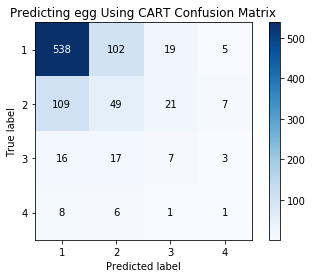

Predicting egg Using CART Accuracy: 0.6545654565456546 Precision:0.3229327260736249 Recall:0.32474313043622355
Predicting egg Using CART model's accuracy is 0.6457040716489801, with a standard deviation of 0.019744622079983922


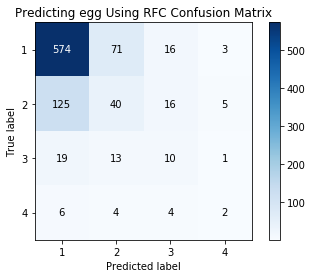

Predicting egg Using RFC Accuracy: 0.6886688668866887 Precision:0.3761317914310048 Recall:0.35926743357526125
Predicting egg Using RFC model's accuracy is 0.6732746293369458, with a standard deviation of 0.017963677926804505


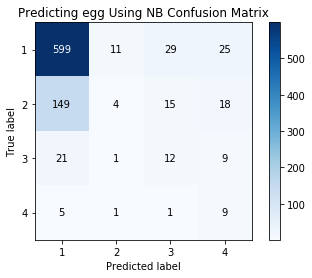

Predicting egg Using NB Accuracy: 0.6864686468646864 Precision:0.34181580645715487 Recall:0.44129589438022154
Predicting egg Using NB model's accuracy is 0.6515390983668248, with a standard deviation of 0.05223311335834835


In [166]:
perform_ml(cleaned_ml_egg_df,"egg")

### Result

It seems like the algorithm is able to predict the lower level class better. It completely fails in predicting the highist level class in all algorithms.


This could be that there is not enough data in the higher class for the algorithm to learn. From the heap map we drew, we can also see that none of the features has a strong correlation with our outcome variable. To improve this we'll first try to look at the number of entries in each class for our outcome variable, and adjust the bins accordingly. Then we will try a few performance improving method such as boosting and bagging. Lastly we will explore other available datasets to serve as features. 

#####  Count Number of Entries in Each Class

In [61]:
for i in range(1,cleaned_ml_egg_df["eggs_group"].max()+1):
    print("Class {} has {} entries".format(i,cleaned_ml_egg_df[cleaned_ml_egg_df["eggs_group"] == i].shape[0]))

Class 1 has 4382 entries
Class 2 has 1193 entries
Class 3 has 369 entries
Class 4 has 116 entries


We can see that the lower two classes have very little numbers of entries.Our bins are not very evenly distributed. Let's try tweakin the bin size. 

#####  More with other outcome variables.
Before we try to improve the performance, let's finish performing machine learning on all other variables. 

This cuts the dairy array into 6 bins in equal width


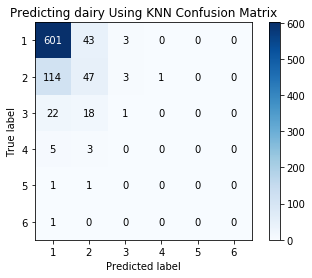

Predicting dairy Using KNN Accuracy: 0.7511574074074074 Precision:0.22838261648745517 Recall:0.20635689271041932
Predicting dairy Using KNN model's accuracy is 0.768233796586119, with a standard deviation of 0.016872791481497392


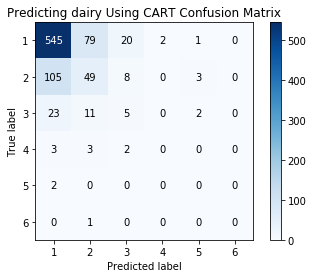

Predicting dairy Using CART Accuracy: 0.6932870370370371 Precision:0.2148915489623454 Recall:0.21021170349401963
Predicting dairy Using CART model's accuracy is 0.7267509703267809, with a standard deviation of 0.01743577894551164


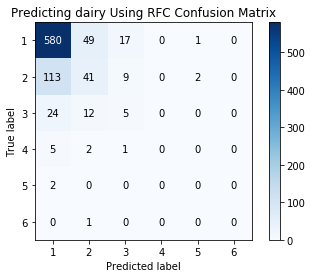

Predicting dairy Using RFC Accuracy: 0.7245370370370371 Precision:0.22463852714198018 Recall:0.21114686656210382
Predicting dairy Using RFC model's accuracy is 0.7488201661032512, with a standard deviation of 0.012273223140548526


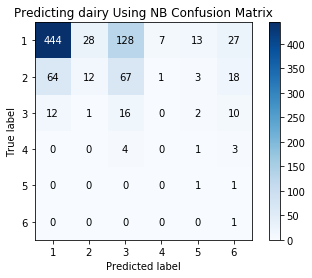

Predicting dairy Using NB Accuracy: 0.5486111111111112 Precision:0.21460239199887524 Recall:0.4415358965308074
Predicting dairy Using NB model's accuracy is 0.563476482617587, with a standard deviation of 0.044512386516257565


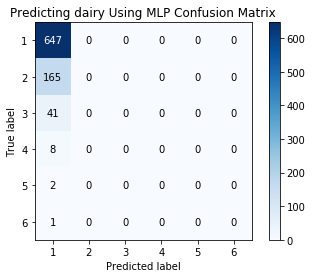

Predicting dairy Using MLP Accuracy: 0.7488425925925926 Precision:0.1248070987654321 Recall:0.16666666666666666
Predicting dairy Using MLP model's accuracy is 0.7788635699678645, with a standard deviation of 0.02197889043386862
This cuts the meat_fish array into 4 bins in equal width


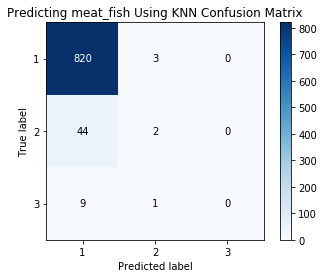

Predicting meat_fish Using KNN Accuracy: 0.9351535836177475 Precision:0.42420771286750664 Recall:0.3466110201278462
Predicting meat_fish Using KNN model's accuracy is 0.9325301204819276, with a standard deviation of 0.008141821258117792


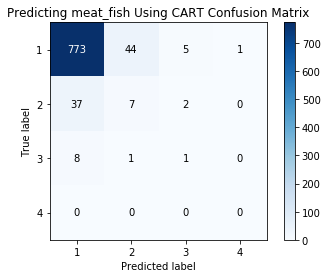

Predicting meat_fish Using CART Accuracy: 0.888509670079636 Precision:0.30115078991912736 Recall:0.2978551429024249
Predicting meat_fish Using CART model's accuracy is 0.8957831325301205, with a standard deviation of 0.012996482831553732


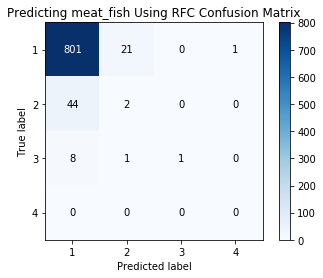

Predicting meat_fish Using RFC Accuracy: 0.9146757679180887 Precision:0.5055930050801094 Recall:0.27918669765967563
Predicting meat_fish Using RFC model's accuracy is 0.9152610441767068, with a standard deviation of 0.009991851650300981


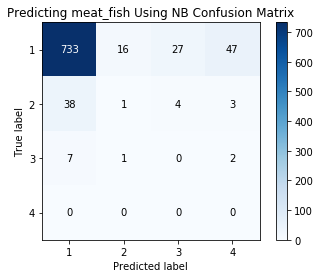

Predicting meat_fish Using NB Accuracy: 0.8350398179749715 Precision:0.24942873464724366 Recall:0.22809577896349517
Predicting meat_fish Using NB model's accuracy is 0.8325301204819278, with a standard deviation of 0.02056052327095616


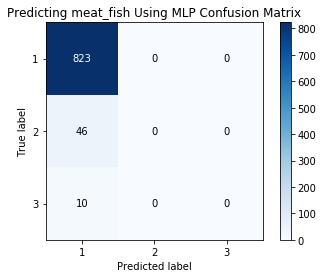

Predicting meat_fish Using MLP Accuracy: 0.9362912400455062 Precision:0.3120970800151687 Recall:0.3333333333333333
Predicting meat_fish Using MLP model's accuracy is 0.9353413654618473, with a standard deviation of 0.008462372492251196
This cuts the nuts_pulses array into 4 bins in equal width


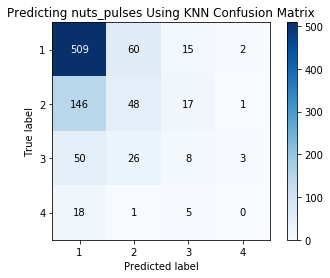

Predicting nuts_pulses Using KNN Accuracy: 0.6215621562156216 Precision:0.30933609958506225 Recall:0.29674244998049626
Predicting nuts_pulses Using KNN model's accuracy is 0.637864077669903, with a standard deviation of 0.012591450747086189


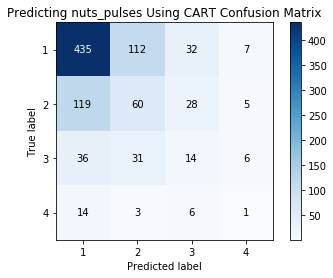

Predicting nuts_pulses Using CART Accuracy: 0.5610561056105611 Precision:0.30977309759159677 Recall:0.306981473483427
Predicting nuts_pulses Using CART model's accuracy is 0.5893203883495145, with a standard deviation of 0.013709617948041838


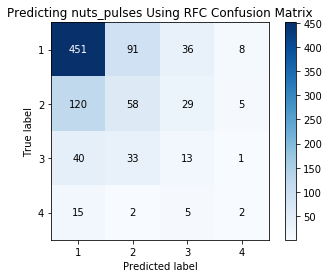

Predicting nuts_pulses Using RFC Accuracy: 0.5764576457645765 Precision:0.329322795418373 Recall:0.318992024932218
Predicting nuts_pulses Using RFC model's accuracy is 0.6139805825242719, with a standard deviation of 0.01770720483911147


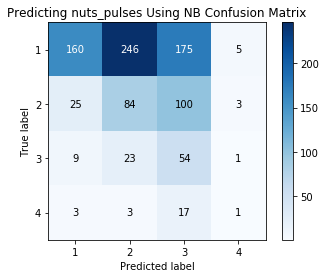

Predicting nuts_pulses Using NB Accuracy: 0.32893289328932895 Precision:0.3260517903645941 Recall:0.3329050698988841
Predicting nuts_pulses Using NB model's accuracy is 0.30466019417475726, with a standard deviation of 0.032111714696601956


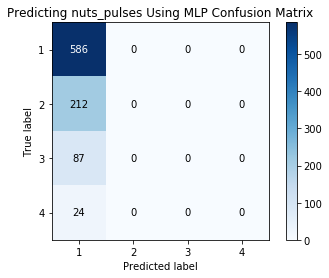

Predicting nuts_pulses Using MLP Accuracy: 0.6446644664466447 Precision:0.16116611661166116 Recall:0.25
Predicting nuts_pulses Using MLP model's accuracy is 0.6506796116504854, with a standard deviation of 0.017742303396524047
This cuts the grains_tubers array into 4 bins in equal width


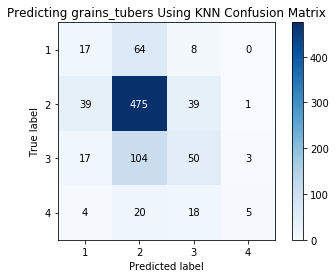

Predicting grains_tubers Using KNN Accuracy: 0.6331018518518519 Precision:0.48188945183830095 Recall:0.3605378146348004
Predicting grains_tubers Using KNN model's accuracy is 0.6287095697174575, with a standard deviation of 0.016324201598908065


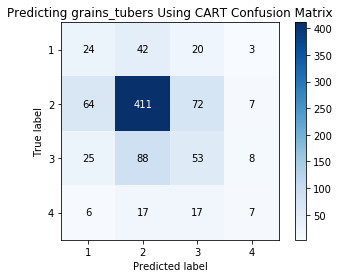

Predicting grains_tubers Using CART Accuracy: 0.5729166666666666 Precision:0.3863500764702536 Recall:0.36626851225704893
Predicting grains_tubers Using CART model's accuracy is 0.5661412294979342, with a standard deviation of 0.018796118932583327


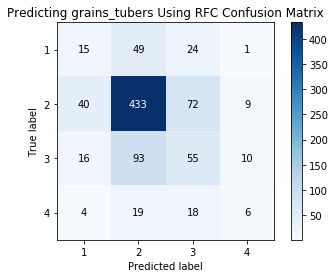

Predicting grains_tubers Using RFC Accuracy: 0.5891203703703703 Precision:0.3712923116769271 Recall:0.34846982549679995
Predicting grains_tubers Using RFC model's accuracy is 0.606213012812487, with a standard deviation of 0.017672372434326827


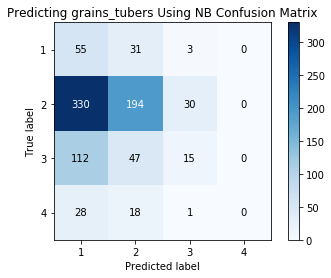

Predicting grains_tubers Using NB Accuracy: 0.3055555555555556 Precision:0.26996246774571897 Recall:0.26359123251419353
Predicting grains_tubers Using NB model's accuracy is 0.3248879429072242, with a standard deviation of 0.0493883754832525


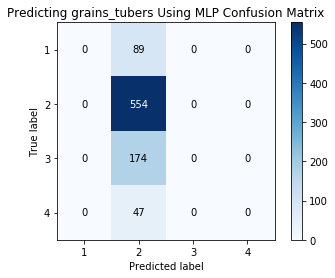

Predicting grains_tubers Using MLP Accuracy: 0.6412037037037037 Precision:0.16030092592592593 Recall:0.25
Predicting grains_tubers Using MLP model's accuracy is 0.6577388255915863, with a standard deviation of 0.01656434607456448
This cuts the animal_source_foods array into 12 bins in equal width


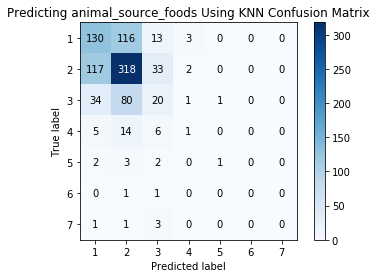

Predicting animal_source_foods Using KNN Accuracy: 0.517051705170517 Precision:0.2779596111703703 Recall:0.2118999018255245
Predicting animal_source_foods Using KNN model's accuracy is 0.5266903740498232, with a standard deviation of 0.025076391351893844


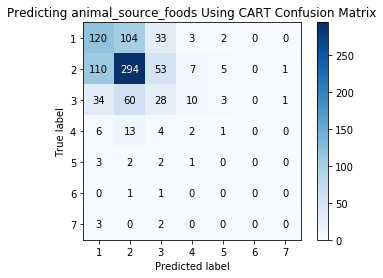

Predicting animal_source_foods Using CART Accuracy: 0.4884488448844885 Precision:0.19566208163064408 Recall:0.1951932302762061
Predicting animal_source_foods Using CART model's accuracy is 0.47020132460299535, with a standard deviation of 0.016416180089362877


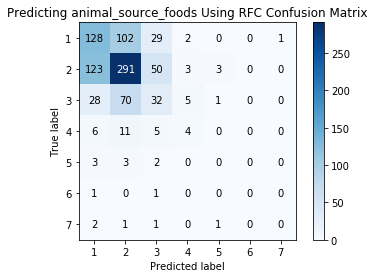

Predicting animal_source_foods Using RFC Accuracy: 0.5005500550055005 Precision:0.22871858660213423 Recall:0.21383411799771945
Predicting animal_source_foods Using RFC model's accuracy is 0.4979604124332053, with a standard deviation of 0.01428473587411738


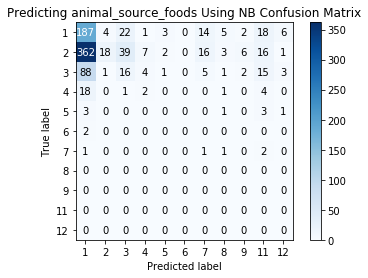

Predicting animal_source_foods Using NB Accuracy: 0.24642464246424642 Precision:0.13102513738901295 Recall:0.10423713328202719
Predicting animal_source_foods Using NB model's accuracy is 0.23374463761571457, with a standard deviation of 0.015146699409155176


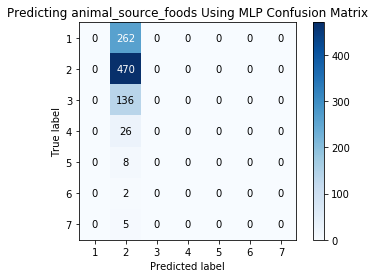

Predicting animal_source_foods Using MLP Accuracy: 0.517051705170517 Precision:0.07386452931007385 Recall:0.14285714285714285
Predicting animal_source_foods Using MLP model's accuracy is 0.526694889741853, with a standard deviation of 0.0096061111245242


In [62]:
# Try it with all others! 
for out_come in dhs_outcome_cols:
    if out_come != "eggs":
        cleaned_outcome_df = clean_outcome(dhs_ml_final_df[[out_come,"Cell_Order"]],out_come)
        cleaned_ml_outcome_df = cleaned_outcome_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
        cleaned_ml_outcome_df = cleaned_ml_outcome_df[desired_group_cols + ["{}_{}".format(out_come,"group")]]
        cleaned_ml_outcome_df.drop(["Cell_Order"], axis=1,inplace = True)
        perform_ml(cleaned_ml_outcome_df,out_come)


##### Try a few Machine Learning Improving Methods 
1) Boosting https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5
    - In this section we will try: Adaboost XGBoost and GradientBoost
    - Decrease Bias 
2) Bagging https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning
    - Decrease Variance 
    - In this section, we will try using bagging with our existing models used above. 
    - *Random tree is a bagged algorithm of decision treee

In [63]:
# Boosting 
# Adaboost https://www.datacamp.com/community/tutorials/adaboost-classifier-python
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [64]:

def perform_boosting_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction.
    Here we are using the default base estimator which is decision tree.
    """
    boosted_models = [('Ada', AdaBoostClassifier(n_estimators=50,learning_rate=1))
                      ,('GB', GradientBoostingClassifier(n_estimators=50,learning_rate=1))
                     ,('XGB', XGBClassifier(n_estimators=50,learning_rate=1))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', boosted_models, out_come,False)


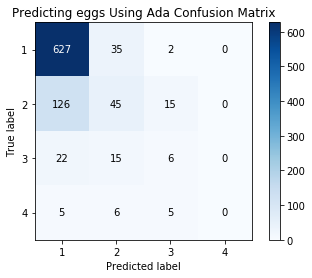

Predicting eggs Using Ada Accuracy: 0.7458745874587459 Precision:0.3659191056468284 Recall:0.33143686900640823
Predicting eggs Using Ada model's accuracy is 0.7369481448031912, with a standard deviation of 0.01482140122273107


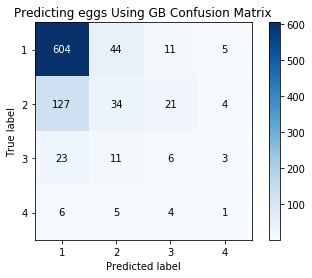

Predicting eggs Using GB Accuracy: 0.7095709570957096 Precision:0.3440547973862643 Recall:0.32361728421563224
Predicting eggs Using GB model's accuracy is 0.709962369233085, with a standard deviation of 0.02285345097003997


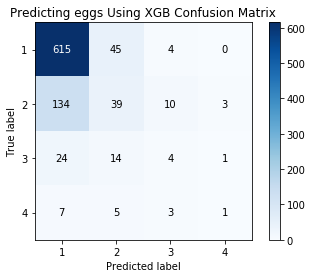

Predicting eggs Using XGB Accuracy: 0.724972497249725 Precision:0.3893946264091895 Recall:0.32285137361147515
Predicting eggs Using XGB model's accuracy is 0.7247185218634755, with a standard deviation of 0.02151532521940104


In [65]:
perform_boosting_ml(cleaned_ml_egg_df,"eggs")

The results above looks promising, the metrics have all improved. Next step I will use GridSearch, a method for finding the best hyperparameters to improve the performance more. 

In [69]:

from sklearn.model_selection import GridSearchCV

In [72]:
# With GridSearch
def perform_grid_boosting_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    
    
    # This param is from https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
    grad_parameters = {
        "learning_rate": [0.5, 0.8, 0.9, 1],
        "subsample":[0.5, 0.8,0.9,1.0],
        "n_estimators":[10]
        }
    
    boosted_models = [
#                         ('Ada', GridSearchCV(AdaBoostClassifier(),parameters,cv=10,n_jobs =-1))
#                       ,('GB', GridSearchCV(GradientBoostingClassifier(),parameters,cv=10,n_jobs =-1))
        ('GB', GridSearchCV(GradientBoostingClassifier(),grad_parameters,cv=10,n_jobs =-1))
#                       ,('XGB', GridSearchCV(XGBClassifier(),parameters,cv=10,n_jobs =-1))
                     ]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', boosted_models, out_come,True)
    

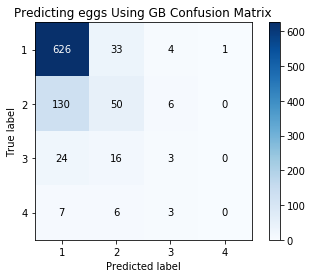

Predicting eggs Using GB Accuracy: 0.746974697469747 Precision:0.364779035820173 Recall:0.3203389326247224
{'learning_rate': 0.5, 'n_estimators': 10, 'subsample': 1.0}


In [73]:
perform_grid_boosting_ml(cleaned_ml_egg_df,"eggs")

In [74]:
#Bagging 
from sklearn.ensemble import BaggingClassifier

In [75]:
def perform_bagging_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    bagged_models = [('KNN', BaggingClassifier(base_estimator= KNeighborsClassifier(), n_estimators=10, max_samples=10, max_features=1.0))
                       , ('CART', BaggingClassifier(base_estimator= DecisionTreeClassifier(), n_estimators=10, max_samples=10, max_features=1.0))
                    ,('NB', BaggingClassifier(base_estimator= GaussianNB(), n_estimators=10, max_samples=10, max_features=1.0))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', bagged_models, out_come, False)

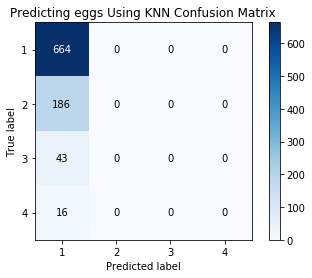

Predicting eggs Using KNN Accuracy: 0.7304730473047305 Precision:0.18261826182618263 Recall:0.25
Predicting eggs Using KNN model's accuracy is 0.7218085346579363, with a standard deviation of 0.021185941853217684


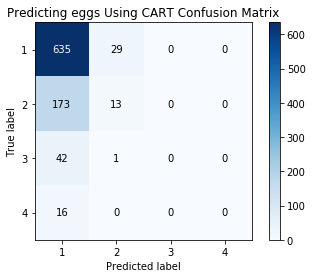

Predicting eggs Using CART Accuracy: 0.7128712871287128 Precision:0.25889548310865246 Recall:0.2565544435807747
Predicting eggs Using CART model's accuracy is 0.712105441408896, with a standard deviation of 0.03764445323666148


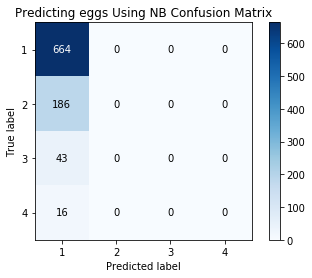

Predicting eggs Using NB Accuracy: 0.7304730473047305 Precision:0.18261826182618263 Recall:0.25
Predicting eggs Using NB model's accuracy is 0.7218085346579363, with a standard deviation of 0.021185941853217684


In [76]:
perform_bagging_ml(cleaned_ml_egg_df,"eggs")

The accuracy is about the same.  I don't think I'll go further into this. 

### New Binning Strategies 

Since our egg class is not very evenly distributed, we are going to divide it more evenly and see if it improves our model performance.
We will first try to bin them so that each class will have equal number of entries. 
If the bin edges are not good enough, we will first build a histogram, and then bin them accordingly.

In [79]:
egg_df = dhs_ml_final_df[["eggs","Cell_Order"]].dropna()

In [80]:


equal_depth_egg_df = create_bins_depth(egg_df,"eggs",4)

cleaned_ml_equal_depth_egg_df = equal_depth_egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_equal_depth_egg_df = cleaned_ml_equal_depth_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_equal_depth_egg_df.drop(["Cell_Order"], axis=1,inplace = True)


This cuts the eggs array into [0.         0.05546218 0.14292923 0.2463752  1.        ] result in 4 bins in equal depth


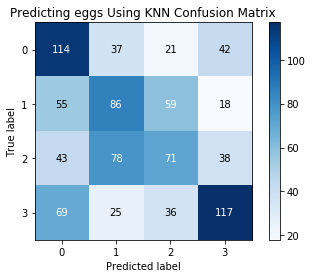

Predicting eggs Using KNN Accuracy: 0.42684268426842686 Precision:0.4275225286314795 Recall:0.4273963889795243
Predicting eggs Using KNN model's accuracy is 0.43758485737939334, with a standard deviation of 0.020310039771443612


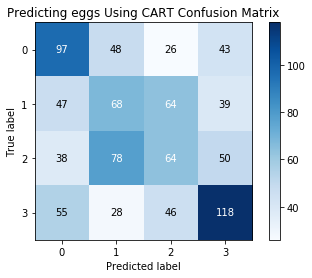

Predicting eggs Using CART Accuracy: 0.38173817381738173 Precision:0.3768972516820618 Recall:0.38029782415736374
Predicting eggs Using CART model's accuracy is 0.3873007450891849, with a standard deviation of 0.014872156322317542


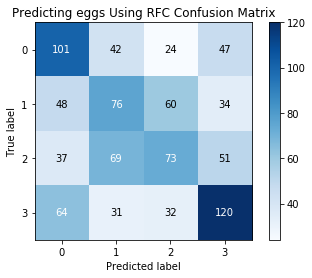

Predicting eggs Using RFC Accuracy: 0.40704070407040704 Precision:0.4037644289112179 Recall:0.4059519334738588
Predicting eggs Using RFC model's accuracy is 0.41021073229472405, with a standard deviation of 0.016816198388274504


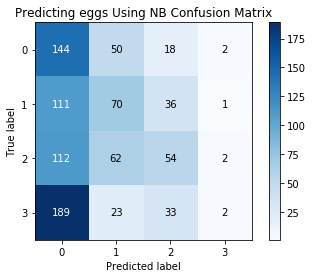

Predicting eggs Using NB Accuracy: 0.297029702970297 Precision:0.31728730737702077 Recall:0.3092194720951075
Predicting eggs Using NB model's accuracy is 0.2981978625724392, with a standard deviation of 0.01623775192210899


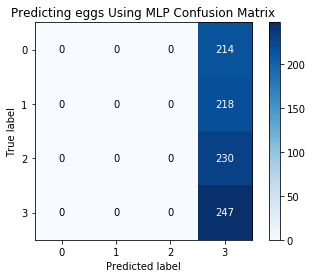

Predicting eggs Using MLP Accuracy: 0.2717271727172717 Precision:0.06793179317931793 Recall:0.25
Predicting eggs Using MLP model's accuracy is 0.2805211861217731, with a standard deviation of 0.020667545813920298


In [81]:
perform_ml(cleaned_ml_equal_depth_egg_df,"eggs")

As we can see, the bin edges are very small, and barely useful. 

In [82]:
# This new binning method is not so great. 
# Gonna try differnt method

bins = [0,0.1,0.2,0.5]
egg_df["eggs_group"] = np.digitize(egg_df["eggs"], bins)
cleaned_ml_our_bin_egg_df = egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_our_bin_egg_df = cleaned_ml_our_bin_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_our_bin_egg_df.drop(["Cell_Order"], axis=1,inplace = True)

In [83]:
cleaned_ml_our_bin_egg_df.head()

,ari_employment value (AVG 2011-2013)_group,agri_gdp_percentage(AVG from 2011 to 2013)_group,AVG GDP 2011-2013 Constant 2010_group,Cons_kg.yr Cereals - Excluding Beer_group,Cons_kg.yr Eggs_group,"Cons_kg.yr Fish, Seafood_group",Cons_kg.yr Meat_group,Cons_kg.yr Milk - Excluding Butter_group,Cons_kg.yr Nuts_and_Seeds_group,Cons_kg.yr Pulses_group,...,Agricultural Emissions (CO2eq)_group,Protected_Terrestrial_group,Forest_change_group,Redlist_group,Freshwater_group,Population_2015_group,Travel_time_to_cities_group,Soil_suit_overall_group,Soil_suit_cereals_group,eggs_group
0,4,2,143040,20,4,4,10,31,1,1,...,3,1,6,2,5,1,9,5,5,3
1,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,1,8,5,5,1
2,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,1,10,5,5,2
3,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,2,10,4,4,3
4,4,2,143040,20,4,4,10,31,1,1,...,3,1,6,2,5,4,6,5,5,1


In [144]:
def check_num_in_class(df,col_name):
    for i in range(1,df[col_name].max()+1):
        print("Class {} has {} entries".format(i,df[df[col_name] == i].shape[0]))

In [145]:
check_num_in_class(cleaned_ml_our_bin_egg_df,"eggs_group")

Class 1 has 1918 entries
Class 2 has 1841 entries
Class 3 has 1816 entries
Class 4 has 485 entries


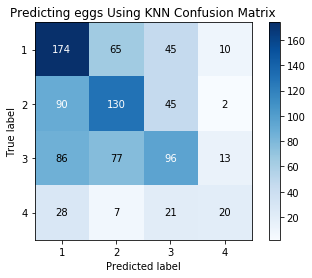

Predicting eggs Using KNN Accuracy: 0.46204620462046203 Precision:0.45861996037311603 Recall:0.42370679791727456
Predicting eggs Using KNN model's accuracy is 0.4509387631747951, with a standard deviation of 0.020610123401180853


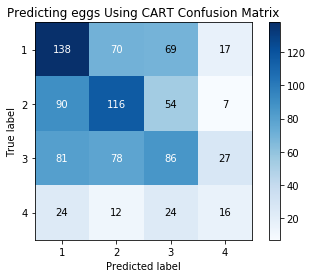

Predicting eggs Using CART Accuracy: 0.39163916391639164 Precision:0.36065223802062096 Recall:0.3576368675796753
Predicting eggs Using CART model's accuracy is 0.40702693513656457, with a standard deviation of 0.020579837706604424


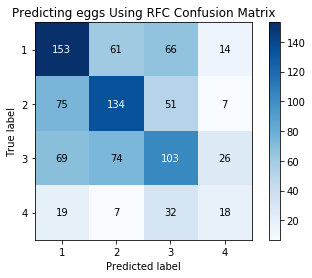

Predicting eggs Using RFC Accuracy: 0.44884488448844884 Precision:0.4138344243049802 Recall:0.40944984957318237
Predicting eggs Using RFC model's accuracy is 0.43636470099354, with a standard deviation of 0.023001097333368033


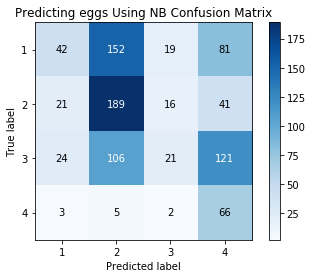

Predicting eggs Using NB Accuracy: 0.34983498349834985 Precision:0.36511736452849264 Recall:0.4490873115952472
Predicting eggs Using NB model's accuracy is 0.31960371727550907, with a standard deviation of 0.023247025651451713


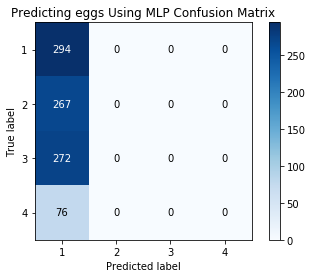

Predicting eggs Using MLP Accuracy: 0.3234323432343234 Precision:0.08085808580858085 Recall:0.25
Predicting eggs Using MLP model's accuracy is 0.31552604737259643, with a standard deviation of 0.019730628627890573


In [155]:
perform_ml(cleaned_ml_our_bin_egg_df,"eggs")

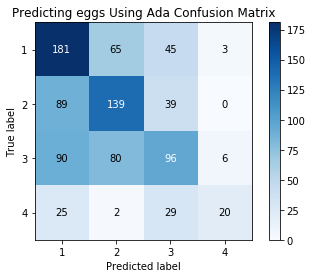

Predicting eggs Using Ada Accuracy: 0.47964796479647964 Precision:0.5262822930245799 Recall:0.43808614516179034
Predicting eggs Using Ada model's accuracy is 0.48764950322994977, with a standard deviation of 0.029114853135315307


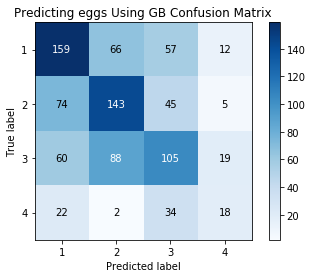

Predicting eggs Using GB Accuracy: 0.4675467546754675 Precision:0.43801018874084 Recall:0.42481709197576134
Predicting eggs Using GB model's accuracy is 0.4719198368025387, with a standard deviation of 0.026598386600672545


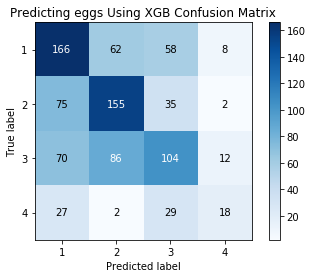

Predicting eggs Using XGB Accuracy: 0.48734873487348734 Precision:0.47737449320423686 Recall:0.4410863103372632
Predicting eggs Using XGB model's accuracy is 0.48493936760983714, with a standard deviation of 0.01920116550794605


In [156]:
perform_boosting_ml(cleaned_ml_our_bin_egg_df,"eggs")

### Run Best Models on Other Variables 

In [158]:
# Milk df 
# Since the dairy column is combined food group. might be better to use the single one. 

milk_bins = [0,0.1,0.2,0.5]

milk_df = dhs_ml_final_df[["Gave.child.tinned..powdered.or.fresh.milk","Cell_Order"]].dropna()
milk_df["milk_group"] = np.digitize(milk_df["Gave.child.tinned..powdered.or.fresh.milk"], milk_bins)
cleaned_ml_our_bin_milk_df = milk_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_our_bin_milk_df = cleaned_ml_our_bin_milk_df[desired_group_cols + ["milk_group"]]
cleaned_ml_our_bin_milk_df.columns

Index(['ari_employment value (AVG 2011-2013)_group',
       'agri_gdp_percentage(AVG from 2011 to 2013)_group',
       'AVG GDP 2011-2013 Constant 2010_group',
       'Cons_kg.yr Cereals - Excluding Beer_group', 'Cons_kg.yr Eggs_group',
       'Cons_kg.yr Fish, Seafood_group', 'Cons_kg.yr Meat_group',
       'Cons_kg.yr Milk - Excluding Butter_group',
       'Cons_kg.yr Nuts_and_Seeds_group', 'Cons_kg.yr Pulses_group',
       'Cons_kg.yr Starchy Roots_group', 'Fish, Seafood_group',
       'Bovine_Sheep_Pigmeat_Poultry_group', 'Milk_Egg_group', 'Cereals_group',
       'Agricultural Emissions (CO2eq)_group', 'Protected_Terrestrial_group',
       'Forest_change_group', 'Redlist_group', 'Freshwater_group',
       'Population_2015_group', 'Travel_time_to_cities_group',
       'Soil_suit_overall_group', 'Soil_suit_cereals_group', 'Cell_Order',
       'Primary_Religion', 'milk_group'],
      dtype='object')

In [162]:
check_num_in_class(cleaned_ml_our_bin_milk_df,"milk_group")

Class 1 has 1910 entries
Class 2 has 1696 entries
Class 3 has 1600 entries
Class 4 has 549 entries


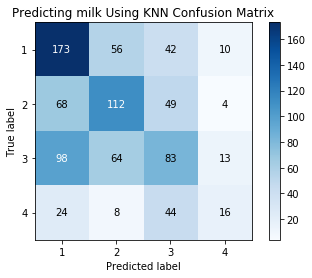

Predicting milk Using KNN Accuracy: 0.4444444444444444 Precision:0.42401941422879413 Recall:0.3979908820257859
Predicting milk Using KNN model's accuracy is 0.45144693460206164, with a standard deviation of 0.015901411173951076


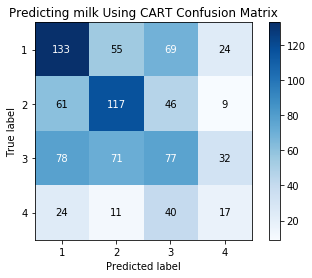

Predicting milk Using CART Accuracy: 0.39814814814814814 Precision:0.3622919676197591 Recall:0.36467193809661486
Predicting milk Using CART model's accuracy is 0.4085008972914319, with a standard deviation of 0.022253033087202268


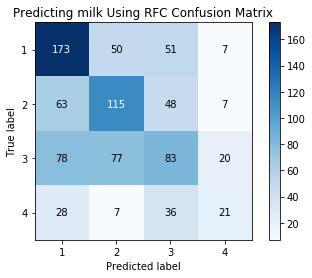

Predicting milk Using RFC Accuracy: 0.4537037037037037 Precision:0.4325618673867294 Recall:0.41479672266769674
Predicting milk Using RFC model's accuracy is 0.4637126998038479, with a standard deviation of 0.023845039797960633


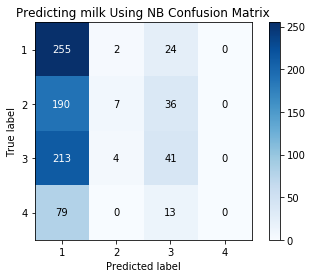

Predicting milk Using NB Accuracy: 0.3506944444444444 Precision:0.31102698689108743 Recall:0.2741077391864118
Predicting milk Using NB model's accuracy is 0.3610684028212512, with a standard deviation of 0.02013011065348151


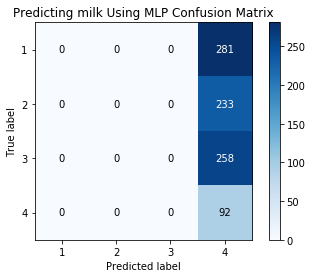

Predicting milk Using MLP Accuracy: 0.10648148148148148 Precision:0.02662037037037037 Recall:0.25
Predicting milk Using MLP model's accuracy is 0.09343850423605024, with a standard deviation of 0.0149821273767031


In [163]:
perform_ml(cleaned_ml_our_bin_milk_df,"milk")

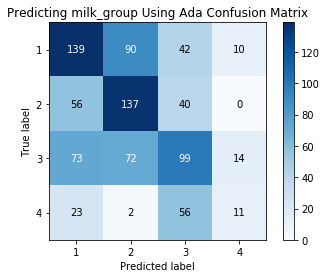

Predicting milk_group Using Ada Accuracy: 0.44675925925925924 Precision:0.4162049912936839 Recall:0.39648272548751834
Predicting milk_group Using Ada model's accuracy is 0.4845736822336296, with a standard deviation of 0.030476765831594508


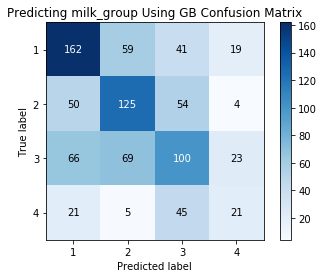

Predicting milk_group Using GB Accuracy: 0.4722222222222222 Precision:0.43910041164636493 Recall:0.4322127277503292
Predicting milk_group Using GB model's accuracy is 0.4851855097867368, with a standard deviation of 0.018700830622975548


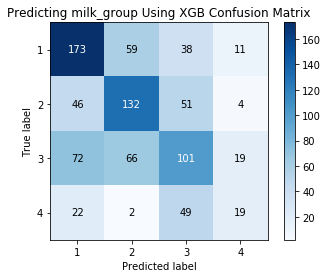

Predicting milk_group Using XGB Accuracy: 0.49189814814814814 Precision:0.460863218225434 Recall:0.4450441438717569
Predicting milk_group Using XGB model's accuracy is 0.5013380075956764, with a standard deviation of 0.023291086380043673


In [164]:
perform_boosting_ml(cleaned_ml_our_bin_milk_df,"milk_group")

In [ ]:
# Other df 

### Regression Models 

###  New Features

1) Road Density https://datacatalog.worldbank.org/dataset/grip-global-roads-inventory-dataset-2018-road-density (Ask Mike for help)
2) Global Cropland and Field Size Still waiting on this resource
3) Add More Country Level Data 

Todo list for this week.
1) For the regression format, I think it would be useful to also look at linear regressions with outcomes bounded from 0 to 1 to predict the % of households reported as consuming the food. I think a linear outcome will be more conducive to creating an overall index of food security, although having multiple models with similar outcomes is always a plus.
2) Similar to 2: what if we were to use a binomial model on the household data to predict consumption vs not consumption? We could then use the % estimates from the binomial outcome (i.e. not which bin the household is most likely to be in, but rather the % likelihood that a household reported consumption for the food group) as an estimate of consumption at the cell level. We could even estimate an RMSE-like equivalent where: actual value = average consumption at the cell, predicted value = % probability from the binomial model when applied to the cell.
3) Switch the data usage to DHS Data by Cell with Regression DAT_24jUNE 2019.
